In [65]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [66]:
#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ML libraries
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef



#Misc libraries
import warnings
warnings.filterwarnings("ignore")

In [67]:
# Define column headers
column_names = ['step', 'transactionType', 'amount', 'startingClient', 'oldBalStartingClient', 'newBalStartingClient', 'destinationClient', 'oldBalDestinationClient', 'newBalDestinationClient', 'isFraud', 'isFlaggedFraud', 'isUnauthorizedOverdraft', 'anonymous']

In [68]:
# Chunking and processing
chunksize = 10 ** 6
df = pd.DataFrame()  # Create an empty DataFrame to store the data

for chunk in pd.read_csv('MoMTSim_20230726095946_1000_rawLog.csv', chunksize=chunksize):
    chunk.columns = column_names  # Assign the column names to the chunk
    chunk = chunk.sample(frac=1.0)  # Apply row sampling to the chunk
    df = pd.concat([df, chunk], ignore_index=True)  # Concatenate each chunk to the DataFrame

In [69]:
# Renaming cashin to deposit, cashout to withdrawal
df['transactionType'] = df['transactionType'].replace({'CASH_IN': 'DEPOSIT', 'CASH_OUT': 'WITHDRAWAL'})

In [70]:
df.head(5)

,step,transactionType,amount,startingClient,oldBalStartingClient,newBalStartingClient,destinationClient,oldBalDestinationClient,newBalDestinationClient,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,anonymous
0,45,PAYMENT,844.61,4619375293562774,4345611.38,4344766.78,36-0008040,22129.24,22973.84,0,0,0,1
1,42,DEPOSIT,226701.79,4990170543916857,2373587.52,2600289.31,99-0009046,82650.83,82650.83,0,0,0,0
2,55,PAYMENT,534.01,4326479098345429,3587261.84,3586727.84,62-0003802,62207.43,62741.44,0,0,0,1
3,2,TRANSFER,29.40,4024862777710853,29.40,0.00,4056831759597688,144321.59,144350.99,1,0,0,1
4,54,PAYMENT,597.27,4125780498764702,137.74,137.74,81-0001382,56615.29,56615.29,0,0,1,0


EDA

In [71]:
import math
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    # nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    nGraphRow = math.ceil(nCol / nGraphPerRow)  # Round up to the nearest integer
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [72]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    # Select only numeric columns for correlation computation
    numeric_columns = df.select_dtypes(include=[np.number])
    if len(numeric_columns) < 2:
        print(f'No correlation plots shown: The number of numeric columns ({len(numeric_columns)}) is less than 2')
        return

    corr = numeric_columns.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()


In [73]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    #df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [74]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8802609 rows and 13 columns


We Choose the first 8 million rows and we visaulise them

In [75]:
# Select the first 1 million rows
subset_df = df.head(5000)

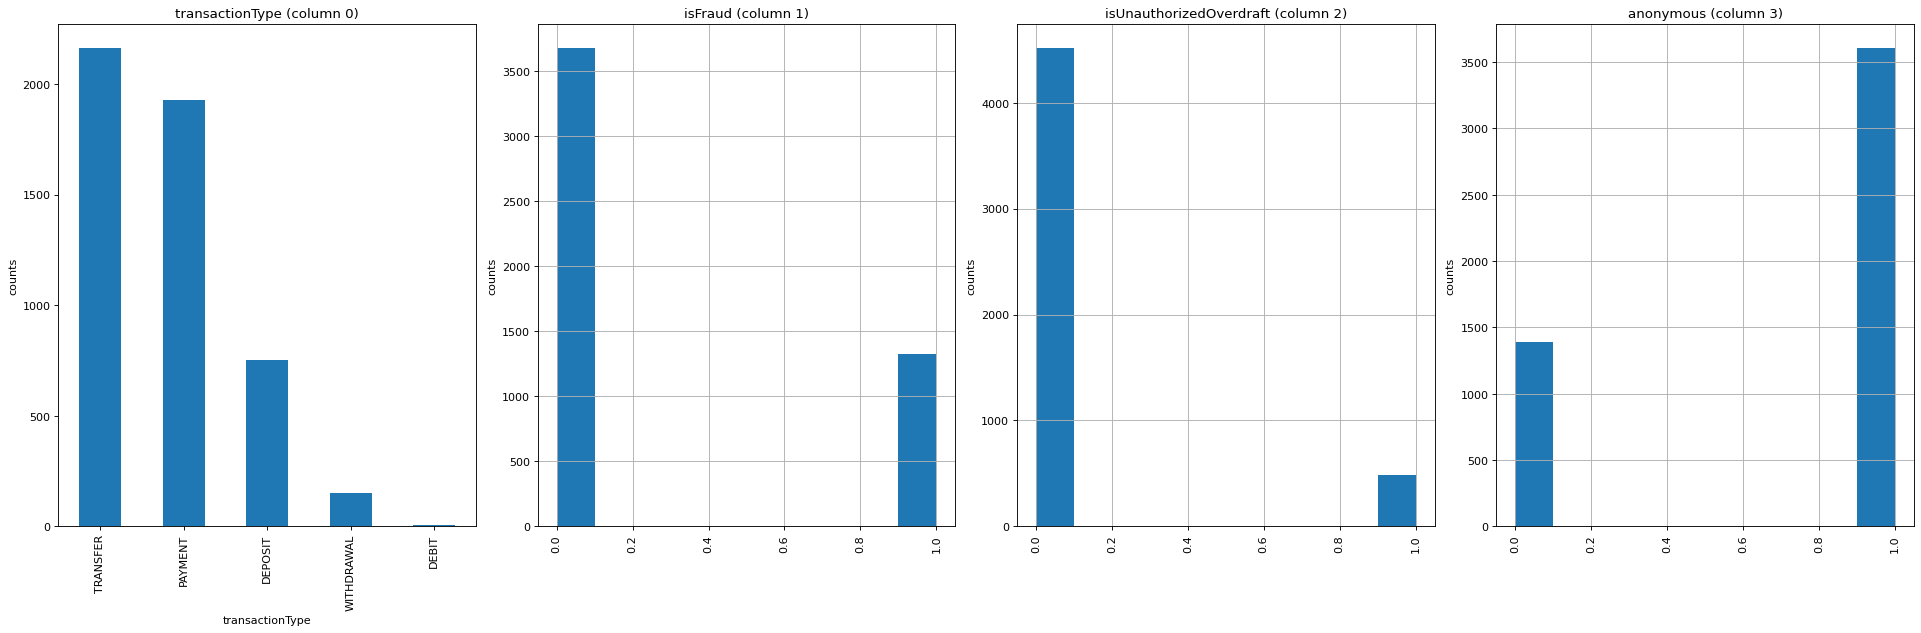

In [76]:
plotPerColumnDistribution(subset_df, 10, 15)

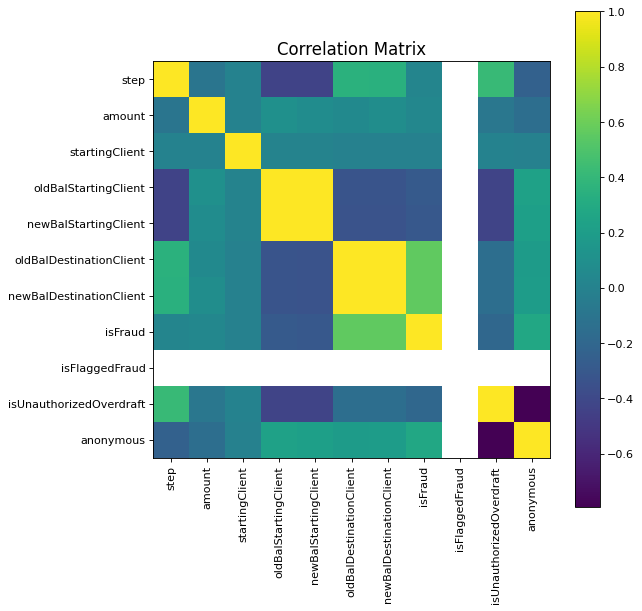

In [77]:
plotCorrelationMatrix(df, 8)

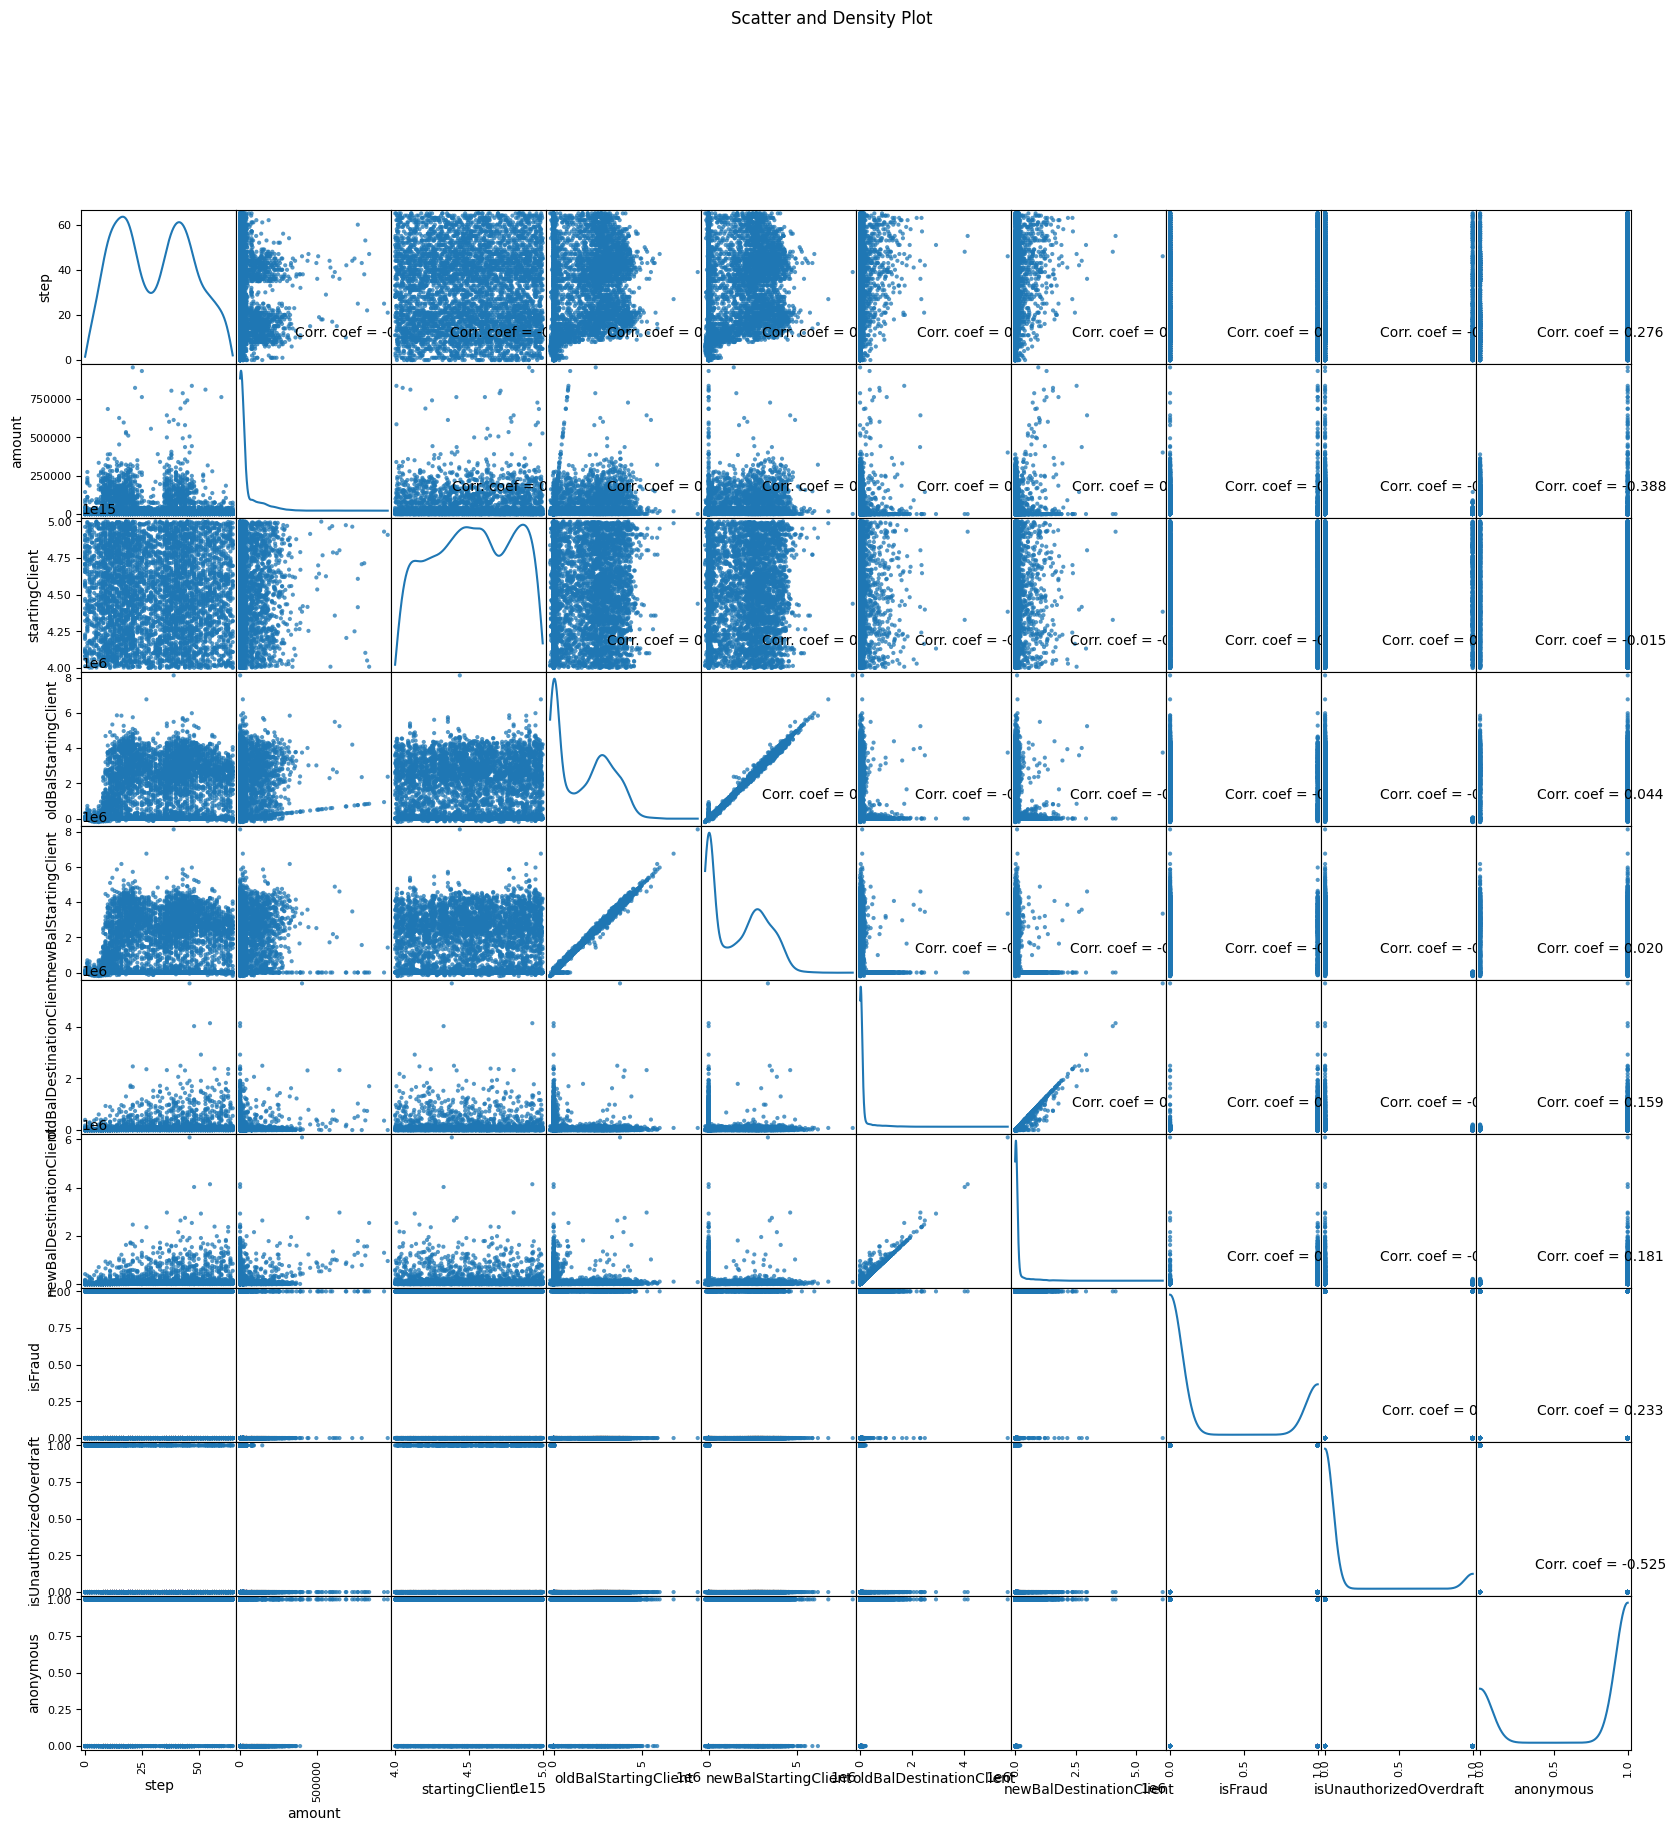

In [78]:
plotScatterMatrix(subset_df, 20, 10)

In [79]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

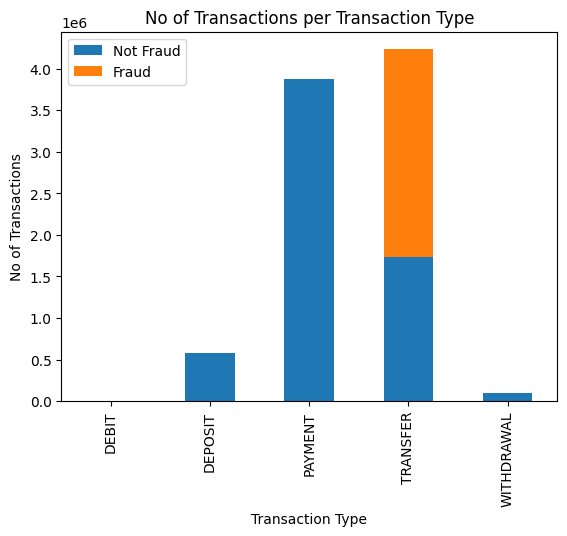

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Group the data by 'transaction_type' and 'isFraud', and count the rows
grouped_data = df.groupby(['transactionType', 'isFraud']).size().unstack()

# Plot the bar graph
ax = grouped_data.plot(kind='bar', stacked=True)

# Set the labels and title
ax.set_xlabel('Transaction Type')
ax.set_ylabel('No of Transactions')
ax.set_title('No of Transactions per Transaction Type')

# Create a legend based on the 'isFraud' column
legend_labels = ['Not Fraud', 'Fraud']
ax.legend(legend_labels)

# Show the plot
plt.show()


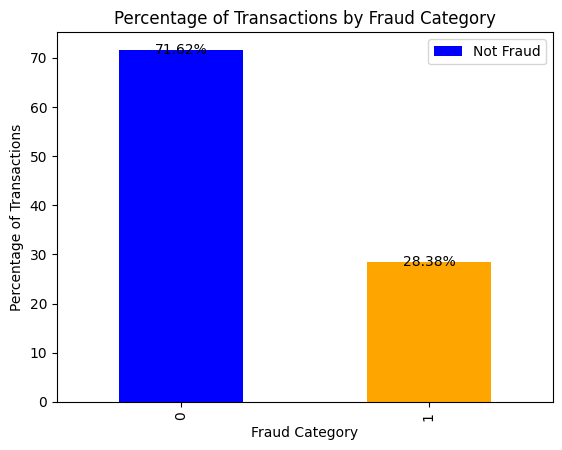

In [81]:
import matplotlib.pyplot as plt

# Group the data by 'isFraud' and calculate the proportions
grouped_data = df['isFraud'].value_counts(normalize=True) * 100

# Plot the bar graph
ax = grouped_data.sort_index().plot(kind='bar', color=['blue', 'orange'])

# Set the labels and title
ax.set_xlabel('Fraud Category')
ax.set_ylabel('Percentage of Transactions')
ax.set_title('Percentage of Transactions by Fraud Category')

# Create a legend based on the 'isFraud' column
legend_labels = ['Not Fraud', 'Fraud']  # Make sure this matches your actual data values
ax.legend(legend_labels)

# Add percentage labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

# Show the plot
plt.show()


Feature Engineering

In [82]:
# Calculate the difference between initial and final balances for customer and recipient
df['customer_balance_change'] = df['newBalStartingClient'] - df['oldBalStartingClient']
df['recipient_balance_change'] = df['newBalDestinationClient'] - df['oldBalDestinationClient']

# Calculate the difference between the transaction amount and customer balance change
df['amount_vs_customer_balance_change'] = df['amount'] - df['customer_balance_change']

# Calculate the difference between the transaction amount and recipient balance change
df['amount_vs_recipient_balance_change'] = df['amount'] - df['recipient_balance_change']

# Calculate the ratio of the transaction amount to the customer's initial balance
df['amount_vs_initial_balance'] = df['amount'] / df['oldBalStartingClient']

# Calculate the ratio of the transaction amount to the recipient's initial balance
df['amount_vs_recipient_initial_balance'] = df['amount'] / df['oldBalDestinationClient']

# Calculate the ratio of the transaction amount to the customer's final balance
df['amount_vs_final_balance'] = df['amount'] / df['newBalStartingClient']

# Calculate the ratio of the transaction amount to the recipient's final balance
df['amount_vs_recipient_final_balance'] = df['amount'] / df['newBalDestinationClient']

# Calculate the time difference between consecutive steps
df['time_diff'] = df.groupby('startingClient')['step'].diff()


# Extract hour of the day from 'step'
df['hour_of_day'] = df['step'] % 24

# Calculate the time interval between transactions
df['time_interval'] = df.groupby(['startingClient'])['step'].diff()

# Compute the transaction frequency for each account
df['transaction_frequency'] = df.groupby(['startingClient'])['startingClient'].transform('count')


# Compute the ratio of transaction amount to average balance of the sender's account
df['amount_to_avg_balance_ratio'] = df['amount'] / df.groupby(['startingClient'])['oldBalStartingClient'].transform('mean')

# Calculate the rolling average transaction amount for each account
df['rolling_avg_amount'] = df.groupby(['startingClient'])['amount'].rolling(window=10, min_periods=1).mean().reset_index(drop=True)



# Compute the number of incoming and outgoing transactions for each account
df['incoming_transactions'] = df.groupby('destinationClient')['destinationClient'].transform('count')
df['outgoing_transactions'] = df.groupby('startingClient')['startingClient'].transform('count')

# Calculate the percentage of fraudulent transactions for each account
df['fraudulent_rate'] = df.groupby('startingClient')['isFraud'].transform('mean') * 100

# Compute the time since the last fraudulent transaction for each account
df['time_since_last_fraud'] = df.groupby('startingClient')['step'].diff().where(df['isFraud'] == 1)

# Calculate the average transaction amount and standard deviation
average_transaction_amount = df['amount'].mean()
std_transaction_amount = df['amount'].std()

# Define the threshold for large transactions
large_transaction_threshold = average_transaction_amount + 2 * std_transaction_amount

# Create a binary feature indicating whether the transaction is large or not
df['is_large_transaction'] = df['amount'].apply(lambda x: 1 if x >= large_transaction_threshold else 0)

# Display the updated DataFrame with new features
df.head()


,step,transactionType,amount,startingClient,oldBalStartingClient,newBalStartingClient,destinationClient,oldBalDestinationClient,newBalDestinationClient,isFraud,...,hour_of_day,time_interval,transaction_frequency,amount_to_avg_balance_ratio,rolling_avg_amount,incoming_transactions,outgoing_transactions,fraudulent_rate,time_since_last_fraud,is_large_transaction
0,45,PAYMENT,844.61,4619375293562774,4345611.38,4344766.78,36-0008040,22129.24,22973.84,0,...,21,NaN,3732,0.000435,72.55,835,3732,11.200429,NaN,0
1,42,DEPOSIT,226701.79,4990170543916857,2373587.52,2600289.31,99-0009046,82650.83,82650.83,0,...,18,NaN,1788,0.153826,87.58,904,1788,13.087248,NaN,1
2,55,PAYMENT,534.01,4326479098345429,3587261.84,3586727.84,62-0003802,62207.43,62741.44,0,...,7,NaN,3264,0.000274,43.87,899,3264,10.968137,NaN,0
3,2,TRANSFER,29.40,4024862777710853,29.40,0.00,4056831759597688,144321.59,144350.99,1,...,2,NaN,1,1.000000,95.39,203,1,100.000000,NaN,0
4,54,PAYMENT,597.27,4125780498764702,137.74,137.74,81-0001382,56615.29,56615.29,0,...,6,NaN,275,0.002449,298823.62,916,275,45.818182,NaN,0


In [83]:
# encode the action column to nemerical values

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the categorical column
le.fit(df['transactionType'])


# Transform the categorical column to numerical values
df['action_encoded'] = le.transform(df['transactionType'])


df.head(5)

,step,transactionType,amount,startingClient,oldBalStartingClient,newBalStartingClient,destinationClient,oldBalDestinationClient,newBalDestinationClient,isFraud,...,time_interval,transaction_frequency,amount_to_avg_balance_ratio,rolling_avg_amount,incoming_transactions,outgoing_transactions,fraudulent_rate,time_since_last_fraud,is_large_transaction,action_encoded
0,45,PAYMENT,844.61,4619375293562774,4345611.38,4344766.78,36-0008040,22129.24,22973.84,0,...,NaN,3732,0.000435,72.55,835,3732,11.200429,NaN,0,2
1,42,DEPOSIT,226701.79,4990170543916857,2373587.52,2600289.31,99-0009046,82650.83,82650.83,0,...,NaN,1788,0.153826,87.58,904,1788,13.087248,NaN,1,1
2,55,PAYMENT,534.01,4326479098345429,3587261.84,3586727.84,62-0003802,62207.43,62741.44,0,...,NaN,3264,0.000274,43.87,899,3264,10.968137,NaN,0,2
3,2,TRANSFER,29.40,4024862777710853,29.40,0.00,4056831759597688,144321.59,144350.99,1,...,NaN,1,1.000000,95.39,203,1,100.000000,NaN,0,3
4,54,PAYMENT,597.27,4125780498764702,137.74,137.74,81-0001382,56615.29,56615.29,0,...,NaN,275,0.002449,298823.62,916,275,45.818182,NaN,0,2


In [84]:
# Replace null values with 0
df.fillna(0, inplace=True)

# Replace infinity values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [85]:
df.drop(['transactionType', 'destinationClient', 'startingClient', 'isFlaggedFraud', 'isUnauthorizedOverdraft', 'anonymous'], axis=1, inplace=True)

In [86]:
# import module
from sklearn.preprocessing import MinMaxScaler



# scale features
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)


In [87]:
df.head()

,step,amount,oldBalStartingClient,newBalStartingClient,oldBalDestinationClient,newBalDestinationClient,isFraud,customer_balance_change,recipient_balance_change,amount_vs_customer_balance_change,...,time_interval,transaction_frequency,amount_to_avg_balance_ratio,rolling_avg_amount,incoming_transactions,outgoing_transactions,fraudulent_rate,time_since_last_fraud,is_large_transaction,action_encoded
0,0.062587,0.000074,0.286098,0.286056,0.006565,0.006389,0.0,0.896788,0.000151,1.480219e-04,...,0.226216,0.321527,0.001721,0.000057,0.587738,0.321527,0.112004,0.341935,0.0,0.50
1,0.058414,0.019865,0.161980,0.176255,0.008417,0.008215,0.0,0.933334,0.000000,8.762738e-10,...,0.226216,0.153999,0.001722,0.000069,0.636364,0.153999,0.130872,0.341935,1.0,0.25
2,0.076495,0.000047,0.238368,0.238343,0.007791,0.007606,0.0,0.896838,0.000096,9.358778e-05,...,0.226216,0.281196,0.001721,0.000034,0.632840,0.281196,0.109681,0.341935,0.0,0.50
3,0.002782,0.000003,0.012590,0.012588,0.010303,0.010103,1.0,0.896919,0.000005,5.153366e-06,...,0.226216,0.000000,0.001722,0.000075,0.142354,0.000000,1.000000,0.341935,0.0,0.75
4,0.075104,0.000052,0.012597,0.012597,0.007620,0.007418,0.0,0.896924,0.000000,5.233808e-05,...,0.226216,0.023613,0.001721,0.234038,0.644820,0.023613,0.458182,0.341935,0.0,0.50


In [88]:
# Splitting Dataset

X= df.drop(columns=['isFraud'])
y=df['isFraud']

In [89]:
# selecting best features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)

In [90]:
feature_names = df.columns

# Get the selected feature indices
selected_feature_indices = fs.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = [feature_names[i] for i in selected_feature_indices]

# Print the names of the selected features
print("Selected feature names:")
print(selected_feature_names)

Selected feature names:
['oldBalStartingClient', 'newBalStartingClient', 'oldBalDestinationClient', 'newBalDestinationClient', 'isFraud', 'time_interval', 'rolling_avg_amount', 'incoming_transactions', 'outgoing_transactions', 'is_large_transaction']


In [91]:
X_selected_features = X_selected
y_selected_features = df['isFraud']

In [92]:
X_train_select_features, X_test_select_features, y_train_select_features, y_test_select_features = train_test_split(
    X_selected_features, y_selected_features, test_size=0.2, random_state=0)

Testing several Algorithms

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef, average_precision_score, recall_score, f1_score, precision_score
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Create a base estimator (weak learner)
base_estimator = DecisionTreeClassifier(max_depth=2)  # Adjust max_depth as needed

# Create an AdaBoostClassifier with adjusted hyperparameters
n_estimators = 50  # Adjust the number of estimators
learning_rate = 0.5  # Adjust the learning rate
max_depth = 10  # Adjust the maximum depth of trees
max_features = "sqrt"  # Adjust the number of features considered at each split


# Creating the objects
logreg_cv = LogisticRegression(solver='liblinear', random_state=12)
nb_cv = GaussianNB()
xg_clf = XGBClassifier(random_state=12)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                               n_estimators=n_estimators,
                               learning_rate=learning_rate,
                               random_state=12)
rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features,
                                       random_state=42)



# cv_dict = {0: 'Logistic Regression', 1: 'Naive Bayes', 2: 'XG Boost', 3: 'Ada Boost', 4: 'Random Forest'}
# 
# cv_models = [logreg_cv, nb_cv, xg_clf, ada_clf, rf_clf]


cv_dict = {0: 'Logistic Regression', 1: 'Naive Bayes', 2: 'XG Boost'}
 
cv_models = [logreg_cv, nb_cv, xg_clf]

results = []

for i, model in enumerate(cv_models):
    accuracy_scores = cross_val_score(model, X_train_select_features, y_train_select_features, cv=10, scoring='accuracy')
    mcc_scores = cross_val_score(model, X_train_select_features, y_train_select_features, cv=10, scoring=make_scorer(matthews_corrcoef))
    precision_scores = cross_val_score(model, X_train_select_features, y_train_select_features, cv=10, scoring=make_scorer(precision_score))
    auprc_scores = cross_val_score(model, X_train_select_features, y_train_select_features, cv=10, scoring=make_scorer(average_precision_score))
    recall_scores = cross_val_score(model, X_train_select_features, y_train_select_features, cv=10, scoring=make_scorer(recall_score))
    f1_scores = cross_val_score(model, X_train_select_features, y_train_select_features, cv=10, scoring=make_scorer(f1_score))
    
    results.append({
        'Model': cv_dict[i],
        'Accuracy': accuracy_scores.mean(),
        'MCC': mcc_scores.mean(),
        'Precision': precision_scores.mean(),
        'AUPRC': auprc_scores.mean(),
        'Recall': recall_scores.mean(),
        'F1-Score': f1_scores.mean()
    })
    print('processed {}'.format(cv_dict[i]))

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

processed Logistic Regression
processed Naive Bayes
processed XG Boost


,Model,Accuracy,MCC,Precision,AUPRC,Recall,F1-Score
0,Logistic Regression,0.915973,0.793310,0.995983,0.787228,0.706851,0.826870
1,Naive Bayes,0.841784,0.665161,0.663499,0.624842,0.898171,0.763203
2,XG Boost,0.916718,0.795564,0.999533,0.789812,0.706954,0.828161


AUPRC stands for "Area Under the Precision-Recall Curve." It is a metric used to evaluate the performance of a binary classification model, particularly in cases where the classes are imbalanced.

The Precision-Recall Curve is a graphical representation that shows the trade-off between precision and recall for different classification thresholds. Precision measures the proportion of true positive predictions among all positive predictions, while recall (sensitivity) measures the proportion of actual positive instances that are correctly predicted.

AUPRC quantifies the overall performance of a model across different levels of precision and recall. It calculates the area under the Precision-Recall Curve, providing a single value that summarizes the model's ability to achieve high precision and high recall simultaneously. A higher AUPRC indicates better model performance, especially in situations where one class is rare (imbalanced dataset) or where the focus is on positive class prediction.

In fraud detection and other similar applications, where correctly identifying positive instances (fraudulent cases) is crucial, AUPRC can be a useful metric to assess how well the model performs across various levels of precision and recall.

In [94]:
cv_dict.values()

dict_values(['Logistic Regression', 'Naive Bayes', 'XG Boost'])

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94   1260998
         1.0       1.00      0.71      0.83    499524

    accuracy                           0.92   1760522
   macro avg       0.95      0.85      0.89   1760522
weighted avg       0.92      0.92      0.91   1760522


Classification Report for GaussianNB:
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88   1260998
         1.0       0.66      0.90      0.76    499524

    accuracy                           0.84   1760522
   macro avg       0.81      0.86      0.82   1760522
weighted avg       0.87      0.84      0.85   1760522


Classification Report for XGBClassifier:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95   1260998
         1.0       1.00      0.71      0.83    499524

    accuracy                           0.92   1760522
 

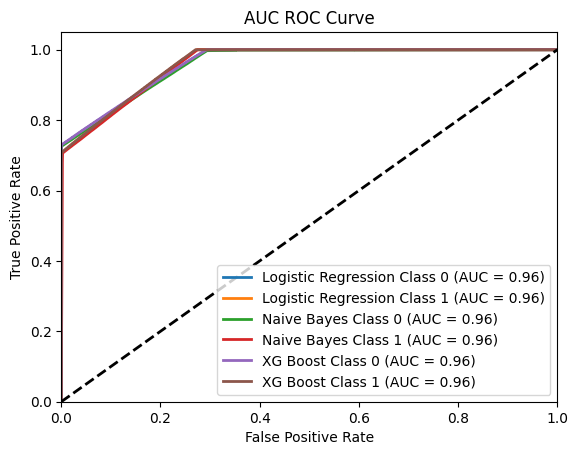

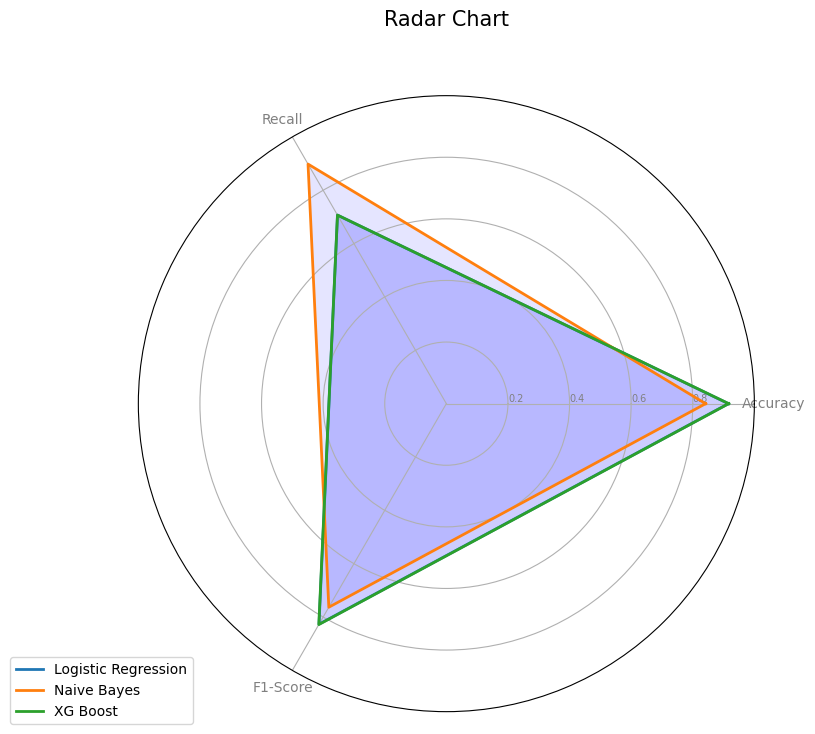

In [95]:
from sklearn.metrics import roc_curve, auc
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef, average_precision_score, recall_score, f1_score, classification_report, precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from math import pi
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Create the objects
logreg_cv = LogisticRegression(solver='liblinear', random_state=12)
nb_cv = GaussianNB()
xg_clf = XGBClassifier(random_state=12)
ada_clf = AdaBoostClassifier(random_state=12)

cv_dict = {0: 'Logistic Regression', 1: 'Naive Bayes', 2: 'XG Boost'}

cv_models = [logreg_cv, nb_cv, xg_clf]

# Binarize the labels for ROC curve (assuming 'y_test' is your test set labels)
y_test_binarized = label_binarize(y_test_select_features, classes=[0, 1, 2])

# Fit the models and get the predicted probabilities
for model in cv_models:
    model.fit(X_train_select_features, y_train_select_features)

y_scores = [model.predict_proba(X_test_select_features) for model in cv_models]

# Draw AUC ROC Curve for all models on the same graph
def plot_roc_curve(models, y_test, y_scores):
    plt.figure()

    for i, model in enumerate(models):
        for class_label in range(y_test.shape[1]):
            try:
                fpr, tpr, _ = roc_curve(y_test[:, class_label], y_scores[i][:, class_label])
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, lw=2,
                         label='{0} Class {1} (AUC = {2:0.2f})'.format(model, class_label, roc_auc))
            except IndexError:
                pass

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Draw Radar Chart
def plot_radar_chart(data, labels, title):
    categories = ['Accuracy', 'Recall', 'F1-Score']
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0, 1)

    for i, (label, values) in enumerate(zip(labels, data)):
        values = np.concatenate((values, [values[0]]))  # Repeat the first value to close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label)
        ax.fill(angles, values, 'b', alpha=0.1)

    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Classification Report
for model in cv_models:
    y_pred = model.predict(X_test_select_features)
    # report = classification_report(y_test_select_features, y_pred, target_names=cv_dict.values())
    report = classification_report(y_test_select_features, y_pred)
    print(f"Classification Report for {model.__class__.__name__}:\n{report}\n")

# Draw AUC ROC Curve for all models on the same graph
models = ['Logistic Regression', 'Naive Bayes', 'XG Boost']
plot_roc_curve(models, y_test_binarized, y_scores)

# Draw Radar Chart
radar_data = [
    results_df.loc[results_df['Model'] == 'Logistic Regression', ['Accuracy', 'Recall', 'F1-Score']].values.flatten(),
    results_df.loc[results_df['Model'] == 'Naive Bayes', ['Accuracy', 'Recall', 'F1-Score']].values.flatten(),
    results_df.loc[results_df['Model'] == 'XG Boost', ['Accuracy', 'Recall', 'F1-Score']].values.flatten()
]
radar_labels = ['Logistic Regression', 'Naive Bayes', 'XG Boost']
plot_radar_chart(radar_data, radar_labels, title='Radar Chart')

Hyper Parameter Tuning of XG Boost

In [96]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import precision_score

# # Define the parameter grid for GaussianNB (no hyperparameters to tune)
# # Define the parameter grid for XG Boost
# param_grid = {
#     'n_estimators': [50, 100, 200],  # Adjust the number of estimators
#     'learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate
#     'max_depth': [5, 10, 20],  # Adjust the maximum depth of trees
#     'max_features': ["sqrt", "log2"]  # Adjust the number of features considered at each split
# }



# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=xg_clf,
#                            param_grid=param_grid,
#                            scoring={
#                                'MCC': make_scorer(matthews_corrcoef),
#                                'Accuracy': make_scorer(accuracy_score),
#                                'F1-Score': make_scorer(f1_score),
#                                'Recall': make_scorer(recall_score)
#                            },
#                            cv=10,
#                            refit='MCC',  # Choose a primary metric for refitting
#                            return_train_score=True,
#                            n_jobs=-1)
# grid_search.fit(X_train_select_features, y_train_select_features)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters for XG Boost:", best_params)

# # Get the best Naive Bayes model
# best_xg_boost_model = grid_search.best_estimator_

# def evaluate_model(model, X_test, y_test):
#     y_pred = model.predict(X_test)
    
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     mcc = matthews_corrcoef(y_test, y_pred)
    
#     print("Precision:", precision)
#     print("Recall:", recall)
#     print("F1-Score:", f1)
#     print("MCC:", mcc)
    
#     return precision, recall, f1, mcc


# # Evaluate the Naive Bayes model using MCC, Precision, F1-Score, and Recall
# precision, recall, f1, mcc = evaluate_model(best_xg_boost_model, X_test_select_features, y_test_select_features)


In [97]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("MCC:", mcc)
    
    return precision, recall, f1, mcc

In [98]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, matthews_corrcoef
import scipy.stats as stats
import numpy as np

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 251, 50),  # Adjust the number of estimators
    'learning_rate': stats.uniform(0.01, 0.2),  # Uniform distribution for learning rate
    'max_depth': np.arange(5, 21, 5),  # Adjust the maximum depth of trees
    'max_features': ["sqrt", "log2"]  # Adjust the number of features considered at each split
}


# Define the scoring metrics you want to use
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'F1-Score': make_scorer(f1_score),
    'Recall': make_scorer(recall_score),
    'MCC': make_scorer(matthews_corrcoef)
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=xg_clf,
                                   param_distributions=param_dist,
                                   scoring=scoring,
                                   cv=10,
                                   refit='MCC',  # Choose a primary metric for refitting
                                   n_iter=50,  # Number of random combinations to try
                                   random_state=42,  # Set a random seed for reproducibility
                                   n_jobs=-1)

# Fit the random search to your data
random_search.fit(X_train_select_features, y_train_select_features)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters for XGBoost:", best_params)

# Get the best XGBoost model
best_xg_boost_model = random_search.best_estimator_

# Evaluate the best model using MCC, Precision, F1-Score, and Recall
precision, recall, f1, mcc = evaluate_model(best_xg_boost_model, X_test_select_features, y_test_select_features)


[12:37:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[12:37:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[12:37:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[12:37:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[12:37:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[12:37:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build